# Cleaning and Exploratory data analysis

In [29]:
import numpy as np
import pandas as pd
import re
import string
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.stem import WordNetLemmatizer
import sys
from sklearn.metrics import classification_report

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

%matplotlib inline
fig_params = {
    'legend.fontsize': 18,
    'axes.labelsize': 18,
    'axes.titlesize': 20,
    'xtick.labelsize': 16,
    'ytick.labelsize': 16,
    'axes.facecolor': '#D9DDD1'
}
plt.rcParams.update(fig_params)

In [2]:
df_train = pd.read_pickle('./data/train.pkl')
df_val = pd.read_pickle('./data/val.pkl')
df_test = pd.read_pickle('./data/test.pkl')

In [3]:
df_train.head()

,user_id,review_id,date,text,type,business_id,funny,useful,cool,stars
106415,fGmrkZJJmeTpNsPoFUf-YQ,VTjp4mzCl9uroa4-zzSayQ,2009-08-05,Great beer selection and awesome location.\nMa...,review,pQ3kRVmttsV1bHxuTf7TAg,0,0,0,3
77506,34gJ_KlP3RM6jotNT6TcDQ,m6nFTE7GVe15lvdIkHh5vw,2012-10-30,"Everyone loves LGO. Well, almost everyone. I s...",review,7SO_rX1F6rQEl-5s3wZxgQ,7,11,10,4
163398,2YP7Tl5UvbrAkAaDya2_kw,KhsS37SlaOhFQdFNl01blw,2011-11-06,I went to dinner here last night. The customer...,review,rhf8H7KZsMHRAprI5-D3sQ,0,0,0,4
210270,kDJ9PRlYugp5RIa9ontPZg,7BMbvTccmfvyeKohaFoFfg,2007-05-06,"Section 105! One season down, I can say that ...",review,V-mvhyX6lxu5l2euYatlrQ,0,1,0,5
142098,uP-k3VT4Ss8fubITUybf-g,Mhl_WFuBOkma4yHGbZT2tw,2011-04-19,Love that this place uses a new disposable pla...,review,Hi5oYFF0ZZkgsYQBK_Q3kQ,0,2,0,3


In [4]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 147140 entries, 106415 to 216615
Data columns (total 10 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   user_id      147140 non-null  object        
 1   review_id    147140 non-null  object        
 2   date         147140 non-null  datetime64[ns]
 3   text         147140 non-null  object        
 4   type         147140 non-null  object        
 5   business_id  147140 non-null  object        
 6   funny        147140 non-null  int64         
 7   useful       147140 non-null  int64         
 8   cool         147140 non-null  int64         
 9   stars        147140 non-null  int64         
dtypes: datetime64[ns](1), int64(4), object(5)
memory usage: 12.3+ MB


## EDA - Part I

In [5]:
df_train['length'] = df_train['text'].apply(lambda x: len(x.split()))

<AxesSubplot:xlabel='length', ylabel='Count'>

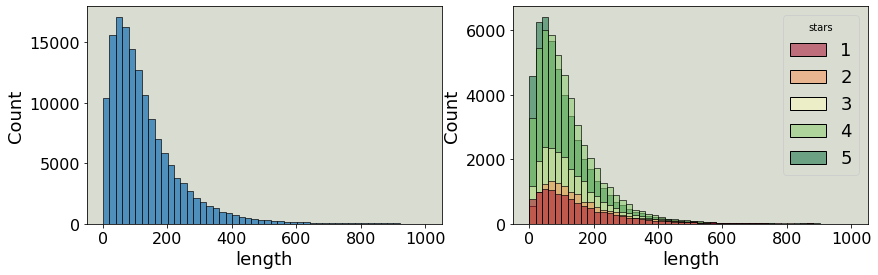

In [6]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14, 4))
sns.histplot(ax=ax[0], data=df_train, x='length', bins=50, palette='RdYlGn')
sns.histplot(ax=ax[1],
             data=df_train,
             x='length',
             bins=50,
             hue='stars',
             palette='RdYlGn')

In [7]:
100 * sum(df_train['length'] > 550) / sum(df_train['length'] > 0)

1.055493254494172

By examining the distribution of the number of words (lengths) of the reviews, many reviews have less than 200 words. There are hardly any reviews (0.75%) with more than 600 words. The length does not correlate well with the number of stars. So set a cutoff as 600 words for the reviews.

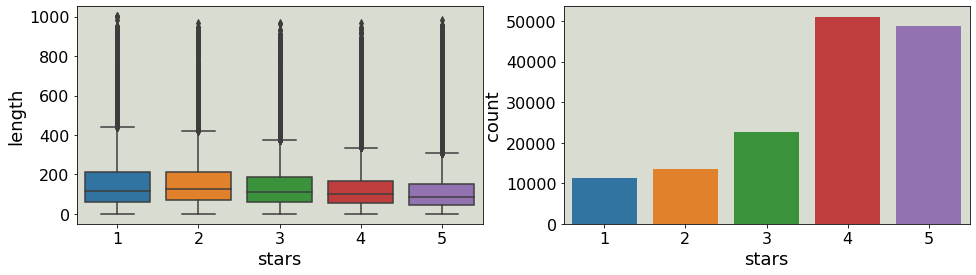

In [8]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 4))
sns.boxplot(ax=ax[0], data=df_train, x='stars', y='length')
sns.countplot(ax=ax[1], data=df_train, x='stars')
plt.show()

In [9]:
stars = df_train.groupby(['stars']).mean()

In [10]:
stars.corr()

,funny,useful,cool,length
funny,1.000000,0.940005,-0.884303,0.980249
useful,0.940005,1.000000,-0.867265,0.896581
cool,-0.884303,-0.867265,1.000000,-0.814728
length,0.980249,0.896581,-0.814728,1.000000


Text(0, 0.5, 'mean values')

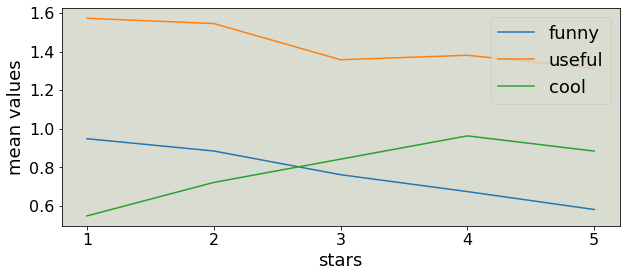

In [11]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 4))
ax.plot(stars.index, stars.funny, label='funny')
ax.plot(stars.index, stars.useful, label='useful')
ax.plot(stars.index, stars.cool, label='cool')
ax.legend()
ax.set_xticks([1, 2, 3, 4, 5])
ax.set_xticklabels([1, 2, 3, 4, 5])
ax.set_xlabel('stars')
ax.set_ylabel('mean values')

When the ratings are not so good, more people find the review useful and funny and less cool.

## Text cleaning

In [12]:
def clean_text(text):
    text = text.lower()
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub(pattern='\n', repl=' ', string=text)
    text = re.sub(pattern='\t', repl=' ', string=text)
    text = re.sub('[0-9]', '', text)
    return text


def remove_stopwords_stemming(stemmer, text, need_stemming=True):
    if bool(need_stemming) == True:
        text_ret = [
            stemmer.stem(word.lower()) for word in text.split()
            if word.lower() not in stopwords.words('english')
        ]
    else:
        text_ret = [
            word.lower() for word in text.split()
            if word.lower() not in stopwords.words('english')
        ]
    return ' '.join(text_ret)


def stemming(stemmer, text):
    list = [stemmer.stem(word) for word in text.split()]
    return ' '.join(list)


def text_processing(text):
    text = clean_text(text)
    text = remove_stopwords_stemming(stemmer, text, need_stemming=True)
    #text=stemming(stemmer,text)
    return text

In [13]:
stemmer = SnowballStemmer(language='english')

In [14]:
df_train['processed'] = df_train['text'].apply(lambda x: text_processing(x))
df_val['processed'] = df_val['text'].apply(lambda x: text_processing(x))
df_test['processed'] = df_test['text'].apply(lambda x: text_processing(x))

In [15]:
df_train['processed']

106415    great beer select awesom locat main complaint ...
77506     everyon love lgo well almost everyon see one t...
163398    went dinner last night custom servic fantast f...
210270    section one season say noth like watch nfl gam...
142098    love place use new dispos plastic inner line s...
                                ...                        
186599    best pastrami sandwich phoenix good usual go n...
15900     truth insid state wooden plaqu mount unassum e...
78266     lvoe italian restaur quit picki discov gem blo...
79645     awesom surpris chandler husband stop dinner la...
216615    plenti reason give five star ahem upscal price...
Name: processed, Length: 147140, dtype: object

## Tokenizing

In [16]:
#pickle.dump(df_train,open('./data/train_final.pkl','wb'))

In [17]:
tokenizer = Tokenizer(num_words=20000, oov_token='<UKN>')

In [18]:
tokenizer.fit_on_texts(df_train['processed'])
pickle.dump(tokenizer, open('./tokenizer_model.model', 'wb'))

In [19]:
def get_sequence(tokenizer, df, maxlen):
    sequence = tokenizer.texts_to_sequences(df)
    padded = pad_sequences(sequences=sequence,
                           maxlen=maxlen,
                           padding='post',
                           truncating='post')
    return padded

In [20]:
maxlen = 550
X_tr = np.array(get_sequence(tokenizer, df_train['processed'], maxlen))
X_cv = np.array(get_sequence(tokenizer, df_val['processed'], maxlen))
X_test = np.array(get_sequence(tokenizer, df_test['processed'], maxlen))

In [21]:
y_tr = df_train['stars']
y_cv = df_val['stars']
y_test = df_test['stars']

In [22]:
print(X_tr.shape, y_tr.shape)
print(X_cv.shape, y_cv.shape)
print(X_test.shape, y_test.shape)

(147140, 550) (147140,)
(36785, 550) (36785,)
(45982, 550) (45982,)


## Create a model

In [26]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, LSTM, Bidirectional, Dropout

In [27]:
model1 = Sequential()
model1.add(Embedding(input_dim=20000, output_dim=30, input_length=maxlen))
model1.add(LSTM(100))
model1.add(Dense(6, activation='softmax'))

model1.compile(loss='sparse_categorical_crossentropy',
               optimizer='adam',
               metrics=['accuracy'])
model1.summary()

NotImplementedError: Cannot convert a symbolic Tensor (lstm_1/strided_slice:0) to a numpy array. This error may indicate that you're trying to pass a Tensor to a NumPy call, which is not supported

In [30]:
print(np.__version__)
print(sys.version)

1.20.2
3.8.10 (default, Jun  4 2021, 15:09:15) 
[GCC 7.5.0]


In [ ]:
model1.fit(X_tr, y_tr, validation_data=(X_cv, y_cv), epochs=10, batch_size=64)

In [ ]:
history = pd.DataFrame(model1.history.history)
history[['loss', 'val_loss']].plot()

In [ ]:
y_tr_pred = model1.predict_classes(X_tr)
y_cv_pred = model1.predict_classes(X_cv)

print('=' * 20)
print('training data \n', classification_report(y_tr, y_tr_pred))
print('=' * 20)
print('validation data \n', classification_report(y_cv, y_cv_pred))
print('=' * 20)

## RNN with dropout layer

In [ ]:
model2 = Sequential()
model2.add(Embedding(input_dim=20000, output_dim=30, input_length=maxlen))
model2.add(Dropout(0.4))
model2.add(LSTM(100))
model2.add(Dropout(0.4))
model2.add(Dense(6, activation='softmax'))

model2.compile(loss='sparse_categorical_crossentropy',
               optimizer='adam',
               metrics=['accuracy'])
model2.summary()

## RNN with bidirectional LSTM  

In [ ]:
model3 = Sequential()
model3.add(Embedding(input_dim=20000, output_dim=30, input_length=maxlen))
model3.add(Dropout(0.2))
model3.add(Bidirectional(LSTM(100)))
model3.add(Dropout(0.4))
model3.add(Dense(6, activation='softmax'))

model3.compile(loss='sparse_categorical_crossentropy',
               optimizer='adam',
               metrics=['accuracy'])
model3.summary()

In [ ]:
model3.fit(X_tr, y_tr, validation_data=(X_cv, y_cv), epochs=10, batch_size=64)

In [ ]:
history = pd.DataFrame(model3.history.history)
history[['loss', 'val_loss']].plot()

In [ ]:
y_tr_pred = model3.predict_classes(X_tr)
y_cv_pred = model3.predict_classes(X_cv)

print('=' * 20)
print('training data \n', classification_report(y_tr, y_tr_pred))
print('=' * 20)
print('validation data \n', classification_report(y_cv, y_cv_pred))
print('=' * 20)

## Test data

In [ ]:
y_test_pred1 = model1.predict_classes(X_test)
y_test_pred2 = model2.predict_classes(X_test)
y_test_pred3 = model3.predict_classes(X_test)

In [ ]:
print('=' * 20)
print(classification_report(y_test, y_test_pred1))
print('=' * 20)
print(classification_report(y_test, y_test_pred2))
print('=' * 20)
print(classification_report(y_test, y_test_pred3))
print('=' * 20)